In [1]:
import csv
from scipy import sparse
from sklearn.cluster import KMeans
import pandas as pd
import networkx as nx
import numpy as np
import time
from scipy.sparse import *
from scipy import *
from sklearn.model_selection import RandomizedSearchCV
import itertools
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming
from numpy import linalg
from matplotlib.pyplot import figure
import random
import scipy
from networkx.algorithms.community import greedy_modularity_communities
import networkx.algorithms.community as nx_comm
from sklearn.cluster import MiniBatchKMeans

In [2]:
def adj_matrix(edge_list, n, is_directed, is_weighted):
    
    A = lil_matrix((n,n), dtype=float)
    f = open(edge_list)
    reader = csv.reader(f)
    #reader = csv.reader(f, delimiter=';') #per roadnet
    
    for line in reader:
        if is_weighted:
            A[int(line[0]),int(line[1])] = round(float(line[2]),2)
        else:
            A[int(line[0]),int(line[1])] = 1
        
        if is_directed==False:
            A[int(line[1]),int(line[0])] = A[int(line[0]),int(line[1])]  
        
    return A

In [3]:
def kmeans(k, t, A):

    kmeans = KMeans(n_clusters=k, init = 'k-means++', algorithm='auto', max_iter=t).fit(A)
    #kmeans = MiniBatchKMeans(n_clusters=k, init = 'k-means++', max_iter=t).fit(A)
    
    # id_supernode : list of id_nodes in it
    partition = {i: np.where(kmeans.labels_ == i)[0] for i in range(k)}
    
    #id_node : id_supernode it belongs to
    supernode = {}
    for k,v in partition.items():
        for el in v:
            supernode[el] = k
  
    return partition, supernode

In [4]:
def lifted_density_matrix(S, n, partition, supernode):
    
    t0 = time.time()
    S_lifted = lil_matrix((n,n), dtype=float) 
    S_grass = lil_matrix((n,n), dtype=float) 
    
    for i in tqdm(range(n)):
        for j in range(n):
            s_i = supernode[i]
            s_j = supernode[j]
            
            S_lifted[i,j] = S[s_i, s_j]
            
            if s_i != s_j :
                S_grass[i,j] = S_lifted[i,j] 
            elif i != j:
                S_grass[i,j] = S_lifted[i,j] * len(partition[s_j])/(len(partition[s_j])-1)   
            else:
                S_grass[i,j] = 0
                
    t1 = time.time()
    print('Running time A_S_lifted + Grass: %f' %(t1-t0))
    return S_lifted,S_grass 

In [5]:
def density_matrix(k, edge_list, partition, A, is_directed, is_weighted, n, supernode):
    
    t0 = time.time()
    
    S = dok_matrix((k,k))        #density matrix of the expected weights
    S_prob = dok_matrix((k,k))
    
    f = open(edge_list)
    reader = csv.reader(f)
    #reader = csv.reader(f, delimiter =';') #per roadnet
    for el in reader:
        el[0]=int(el[0])
        el[1]=int(el[1])
        if is_weighted:
            S[supernode[el[0]], supernode[el[1]]] +=  A[el[0],el[1]]
            S_prob[supernode[el[0]], supernode[el[1]]] += 1
        else: 
            S[supernode[el[0]], supernode[el[1]]] +=  1
        if is_directed==False:
            S[supernode[el[1]], supernode[el[0]]] +=  A[el[0],el[1]]
        
    for i in range(k): 
        for j in range(k): 
            den = len(partition[i])*len(partition[j])
            S[i,j] = S[i,j]/den
            S_prob[i,j] = S_prob[i,j]/den
            
    t1 = time.time()
    print('Running time S (kxk): %f' %(t1-t0))
    
   # S_probs, S_probs_G = lifted_density_matrix(S_prob,n,partition,supernode)
   # S, S_G = lifted_density_matrix(S,n,partition,supernode)
    #return  S_probs, S_probs_G,  S, S_G
    return S

In [6]:
def summ_A(edge_list, n, k, t, is_directed, is_weighted):
    
    t2 = time.time()
    A = adj_matrix(edge_list, n, is_directed, is_weighted)
    t3  = time.time()
    print('Running time adj_matrix: %f' %(t3-t2))


    #partition given by the clustering
    t6 = time.time()
    partition, supernode = kmeans(k, t, A)
    t7 = time.time()
    print('Running time kmeans: %f' %(t7-t6))

    
    S = density_matrix(k, edge_list, partition, A, is_directed, is_weighted, n, supernode)                        


    return S, partition, supernode

In [81]:
# FACEBOOK
k = 500
S, partition, supernode = summ_A('fb.csv', 4039, k, 20, False, False)

Running time adj_matrix: 0.797201
Running time kmeans: 31.363299
Running time S (kxk): 14.827436


In [49]:
# LASTFM
t0 = time.time()
k = 1730
S, partition, supernode = summ_A('lastfm.csv', 7624, k, 20, False, False)
t1 = time.time()

print('Total running time: %f' %(t1-t0)) 

Running time adj_matrix: 0.281117
Running time kmeans: 124.403846
Running time S (kxk): 144.252876
Total running time: 268.946826


In [8]:
# ENRON MAIL
k = 6137
S, partition, supernode = summ_A('en.csv', 36692, k, 20, False, False)

Running time adj_matrix: 6.680871
Running time kmeans: 3816.122313
Running time S (kxk): 1830.307108


In [72]:
# GNUTELLA (K = 500,750,1000)
#analysis on the largest cc
k = 1000
S, partition, supernode = summ_A('gnutella.csv', 6301, k, 20, True, False)

Running time adj_matrix: 0.282711
Running time kmeans: 32.334011
Running time S (kxk): 49.557666


In [86]:
# UBUNTU (K = 350,500,750)
k = 750
#S_probs, S_probs_G,  S, S_G, partition, supernode = summ_A('ubuntu.csv', 3035, k, 20, False, True)
S, S_prob, partition, supernode = summ_A('ubuntu.csv', 3035, k, 20, False, True)

Running time adj_matrix: 2.707775
Running time kmeans: 71.490785
Running time S (kxk): 34.676456


## Thresholding

In [12]:
A = adj_matrix('lastfm.csv', 7624, False, False)

In [14]:
n = 3035

In [77]:
# discretize 
# A -> 0 remains 0, values different from zeros became 1
#A_th = lil_matrix((n,n), dtype=float) 
#A_th[A>0] = 1


th = 0.75
# thresholding for number of SuperEdges
S_probs_th = lil_matrix((n,n), dtype=float) 
S_probs_th[S_probs<th] = 0
S_probs_th[S_probs>=th] = 1

# thresholding for l2 error
S_th = S
S_th[S_probs<th] = 0

In [78]:
#l2 error
print('Error l2: with A_S', round(linalg.norm(A.A-S_th.A)))

Error l2: with A_S 17299


In [79]:
#Number of SuperEdges
print('Edges in the Grass lifted summary matrix',np.count_nonzero(S_probs_th.A))

Edges in the Grass lifted summary matrix 65925


## Clusters densities

In [46]:
# cluster : size
cluster={}
for k,v in partition.items():
    cluster[k] = len(v)
s = np.array([key for key, val in cluster.items() for _ in range(val)])

In [47]:
n = 6301

In [48]:
print('median', np.median(list(cluster.values())))
print('mean', np.mean(list(cluster.values())))
print('variance', np.var(list(cluster.values())))
print('max', np.max(list(cluster.values())))
print('max percentage', np.max(list(cluster.values()))/n*100)

median 1.0
mean 12.602
variance 60084.523595999985
max 5488
max percentage 87.09728614505634


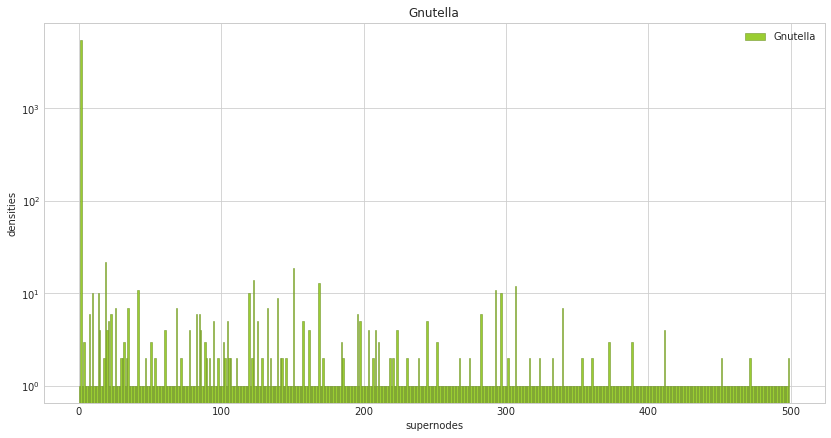

In [50]:
#cluster distribution

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(s, bins=k, facecolor = 'yellowgreen', edgecolor='olivedrab',  linewidth=0.5, log=True, label = 'Gnutella')
plt.title('Gnutella') 
plt.xlabel('supernodes') 
plt.ylabel('densities') 
plt.legend(loc="upper right")
plt.show()

## Degree queries

In [8]:
A = adj_matrix('ubuntu.csv', 3035, False, True)

In [56]:
#save the errors for any threshold
s_tot = []
s_out_tot = []
s_in_tot = []

In [57]:
n = 3035

In [90]:
# discretize 
# A -> 0 remains 0, values different from zeros became 1
#A[A>0] = 1
# grass -> negative values became 0, positive values 1 

#Th = 0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.75
probs_G = lil_matrix((n,n), dtype=float) 
probs_G[S_prob<0.75] = 0
probs_G[S_prob>=0.75] = 1

In [70]:
#discretize for weighted degree
S_G_dq = S_G 
S_G_dq[S_probs_G<0.75]= 0

In [71]:
#out degree queries percentage
s = []

for i in tqdm(range(n)):
    sumA = np.sum(A[i,:])
    #sumS = np.sum(probs_G[i,:])
    sumS = np.sum(S_G_dq[i,:])
    if sumA !=0:
        s.append((abs(sumA - sumS))/sumA )
    
s_tot.append(round(np.mean(s),2))
print("Average error in adjacency queries", np.mean(s))

100%|██████████| 3035/3035 [00:02<00:00, 1501.14it/s]

Average error in adjacency queries 0.9224668951032251


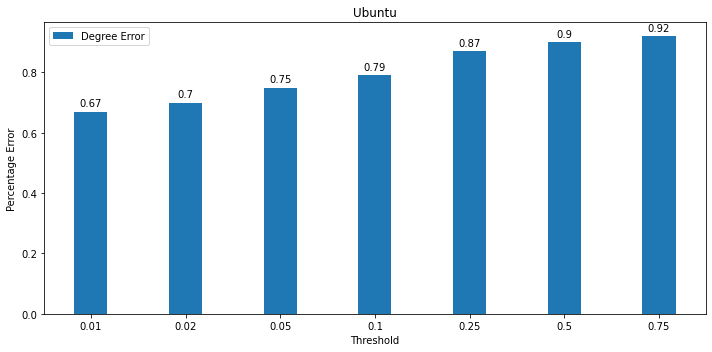

In [72]:
labels = [0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.75]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)
rects1 = ax.bar(x , s_tot , width, label='Degree Error')
#rects2 = ax.bar(x + width/2, s_in_tot, width, label='In Degree Error')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylim(0, 1.3)
ax.set_xlabel('Threshold')
ax.set_ylabel('Percentage Error')
ax.set_title("Ubuntu")
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## Weights comparison

In [24]:
A = adj_matrix('ubuntu.csv', 3035, False, True)
G = nx.from_numpy_matrix(np.matrix(A.A), create_using=nx.Graph)

In [10]:
#summary graph
s = nx.from_numpy_matrix(np.matrix(S.A), create_using=nx.Graph)

In [12]:
def get_edge_attributes(G, name):
    edges = G.edges(data=True)
    return [ x[-1]['weight'] for x in edges]

In [13]:
w_G = get_edge_attributes(G, 'weight')
w_S = get_edge_attributes(s, 'weight')

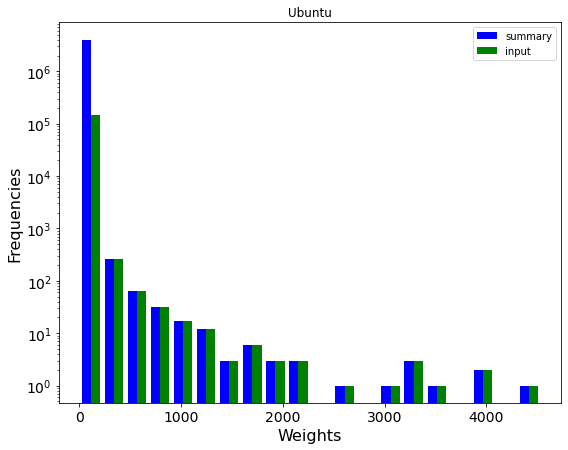

In [14]:
colors = ['b','g']
#plots the histogram
fig, ax1 = plt.subplots(figsize=(9,7))
ax1.hist([w_S, w_G],color=colors, bins=20, log=True, label = ['summary','input'])
plt.title("Ubuntu")
plt.xlabel("Weights", fontsize=16)  
plt.ylabel("Frequencies", fontsize=16)
plt.legend(loc="upper right")
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.show()

## Queries on S (kxk) 

In [51]:
A = adj_matrix('fb.csv', 4039, False, False)

In [50]:
A = adj_matrix('lastfm.csv', 7624, False, False)

In [10]:
A = adj_matrix('gnutella.csv', 6301, True, False)

In [33]:
A = adj_matrix('ubuntu.csv', 3035, False, True)

In [65]:
A = adj_matrix('roadnet.csv', 1090142, False, False)

In [51]:
#input
G = nx.from_numpy_matrix(np.matrix(A.A), create_using=nx.Graph)

In [41]:
# input for Enron
Data = open('en.csv', "r")
G = nx.parse_edgelist(Data, delimiter=',', create_using=nx.Graph,nodetype=int)

In [66]:
# input for roadnet
Data = open('roadnet.csv', "r")
G = nx.parse_edgelist(Data, delimiter=';', create_using=nx.Graph,nodetype=int)

In [77]:
#summary
s = nx.from_numpy_matrix(np.matrix(S.A), create_using=nx.Graph)

In [31]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

In [12]:
scc = sorted(nx.connected_components(s), key=len, reverse=True)
s0 = s.subgraph(scc[0])

In [13]:
#diameter
t0 = time.time()
print(nx.diameter(s0))
t1 = time.time()
print('Running time', round(t1-t0,2))
#enron

4
Running time 4.02


In [9]:
#average clustering
t0 = time.time()
nx.average_clustering(s)
t1 = time.time()
print('Running time',round(t1-t0,2))

Running time 4.62


In [15]:
# minimum cut
t0 = time.time()
print(nx.minimum_node_cut(s0))
t1 = time.time()
print('Running time', round(t1-t0,2))

{0}
Running time 22.46


## Triangles

In [99]:
#triangles
t0 = time.time()
np.sum(list(nx.triangles(G).values())) / 3
t1 = time.time()
print('running time', round(t1-t0,2))

running time 5.79


In [119]:
#Riondato for undirected graphs
t0=time.time()
t = 0
for i in tqdm(range(k)):
    n_i = len(partition[i])
    pi_ii = S[i,i] * n_i / (n_i - 1) if n_i > 1 else 0
    t += scipy.special.binom(n_i,3) * pi_ii**3
    for j in range(i+1, k):
        pi_ij = S[i,j]
        n_j = len(partition[j])
        pi_jj = S[j,j] * n_j / (n_j-1) if n_j > 1 else 0
        t += pi_ij**2*(scipy.special.binom(n_i,2)*n_j*pi_ii + scipy.special.binom(n_j,2)*n_i*pi_jj)
        for w in range(j+1,k):
            n_w = len(partition[w])
            pi_jw = S[j,w]
            pi_wi = S[w,i]
            t += n_i*n_j*n_w*pi_ij*pi_jw*pi_wi
print("Expected Number of triangles: ", round(t))
t1 = time.time()
print('Running time',round(t1-t0,2))

#ENRON 1,500

100%|██████████| 1500/1500 [3:40:54<00:00,  8.84s/it] 

Expected Number of triangles:  4154516
Running time 13254.29


In [13]:
#Riondato for directed graphs
t = 0
for i in tqdm(range(k)):
    n_i = len(partition[i])
    pi_ii = S_prob[i,i] * n_i / (n_i - 1) if n_i > 1 else 0
    t += scipy.special.binom(n_i,3) * pi_ii**3
    for j in range(i+1, k):
        pi_ij = (S_prob[i,j] + S_prob[j,i]) - (S_prob[i,j] * S_prob[j,i])
        n_j = len(partition[j])
        pi_jj = S_prob[j,j] * n_j / (n_j-1) if n_j > 1 else 0
        t += pi_ij**2*(scipy.special.binom(n_i,2)*n_j*pi_ii + scipy.special.binom(n_j,2)*n_i*pi_jj)
        for w in range(j+1,k):
            n_w = len(partition[w])
            pi_jw = (S_prob[j,w] + S_prob[j,w]) - (S_prob[j,w] * S_prob[j,w])
            pi_wi = (S_prob[w,i] + S_prob[i,w]) - (S_prob[w,i] * S_prob[i,w])
            t += n_i*n_j*n_w*pi_ij*pi_jw*pi_wi
print("Expected Number of triangles: ", round(t))


  0%|          | 0/350 [00:00<?, ?it/s]


NameError: name 'S_prob' is not defined

## Centrality

In [52]:
#summary graph
s = nx.from_numpy_matrix(np.matrix(S.A), create_using=nx.Graph)

In [11]:
def precision(k, l1, l2):
    l3 = [value for value in l1 if value in l2]
    intersect = len(l3)
    return intersect/k

In [53]:
prG = nx.closeness_centrality(G)
prS = nx.closeness_centrality(s)

AttributeError: module networkx has no attribute single_source_shortest_path_length

In [13]:
#normalization for pagerank
for i in range(k):
    prS[i] = prS[i]/len(partition[i])

In [30]:
#normalization for the degree centrality
for i in range(k):
    if S[i,i] !=0:
        prS[i] = prS[i] + (len(partition[i]) - 1)#*S_prob[i,i]

In [31]:
#assign the centrality of the supernode to the nodes inside it
prSG = {}
for k,v in prS.items():
    for el in partition[k]:
        prSG[el] = v

In [35]:
th = sorted(list(prSG.values()), reverse=True)[199]

In [36]:
for idx,el in enumerate(sorted(list(prSG.values()), reverse=True)):
    if el<th:
        print(idx)
        k2 = idx
        break

5631


In [37]:
k1 = 200
l1 = sorted(prG, key=prG.get, reverse=True)[:k1]
l2 = sorted(prSG, key=prSG.get, reverse=True)[:k2]

# measures
r = precision(k1,l1,l2)
p = precision(k2,l1,l2)
print('Precision:', p)
print('Recall:', r)
print('f1 measure', 2*p*r/(p+r))

Precision: 0.0
Recall: 0.0


ZeroDivisionError: float division by zero

## Core decomposition

In [24]:
t0  = time.time() 
coreG = nx.core_number(G)
t1 = time.time()
print('running time', round(t1-t0,2))

running time 1.05


In [23]:
t0 = time.time()
s.remove_edges_from(nx.selfloop_edges(s))
coreS = nx.core_number(s)
t1 = time.time()
print('running time', round(t1-t0,2))

running time 0.47


In [48]:
coreS_dict = {}
for k, v in coreS.items():
    for node in partition[k]:
        coreS_dict[node] = v 

In [49]:
#inner most core

l1 = [k for k in coreG.keys() if coreG[k]==max(coreG.values())]
l2 = [k for k in coreS_dict.keys() if coreS_dict[k]==max(coreS_dict.values())]

# measures
r = precision(len(l1),l1,l2)
p = precision(len(l2),l1,l2)
print('Precision:', p)
print('Recall:', r)
print('f1 measure', 2*p*r/(p+r))

Precision: 0.011705685618729096
Recall: 0.9607843137254902
f1 measure 0.023129572810951144


## Shortest Path

In [19]:
# sample 100 couples of nodes 
cc = nx.connected_components(G)
largest_cc = sorted(nx.connected_components(G))[0]
sample1 = random.sample(largest_cc, 1)
sample2 = random.sample(largest_cc, 1)
sample = [list(x) for x in zip(sample1, sample2)]

In [94]:
t0 = time.time()
nx.shortest_path_length(G, source=sample1[0], target=sample2[0], weight= 'weight', method='dijkstra')
t1 = time.time()
print('running time', round(t1-t0,2))

running time 0.24


In [20]:
def shortest_distance(G,start,w):
    
    shortestDistance = float("inf")
    for n in G.neighbors(source): 
        currentDistance = nx.shortest_path_length(s, source=n, target=start, weight= w, method='dijkstra')
        if currentDistance < shortestDistance:
            target = n
        shortestDistance = min(currentDistance, shortestDistance)
        
    return shortestDistance+1 if w==None else shortestDistance+S[start,n]

In [22]:
t0 = time.time()
s_i = supernode[sample1[0]]
s_j = supernode[sample2[0]]
if s_i == s_j:
    if S[s_i, s_i] != 0:
         spS = S[s_i,s_j]
    else:
        spS = shortest_distance(s, s_i, 'weight')



else:
    spS = nx.shortest_path_length(s, source=s_i, target=s_j, weight='weight', method='dijkstra')
t1 = time.time()
print('running time', round(t1-t0,2))

running time 0.02


In [44]:
# sample 1000 couples of nodes 
sample1 = random.sample(G.nodes(), 1000)
sample2 = random.sample(G.nodes(), 1000)
sample = [list(x) for x in zip(sample1, sample2)]

In [55]:
# sample 100 couples of nodes 
cc = nx.connected_components(G)
largest_cc = sorted(nx.connected_components(G), key=len)[-1]
sample1 = random.sample(largest_cc, 1000)
sample2 = random.sample(largest_cc, 1000)
sample = [list(x) for x in zip(sample1, sample2)]

In [50]:
def shortest_distance(G,start,w):
    
    shortestDistance = float("inf")
    for n in G.neighbors(source): 
        currentDistance = nx.shortest_path_length(s, source=n, target=start, weight= w, method='dijkstra')
        if currentDistance < shortestDistance:
            target = n
        shortestDistance = min(currentDistance, shortestDistance)
        
    return shortestDistance+1 if w==None else shortestDistance+S[start,n]

In [56]:
def shortest_path(G, s, couple):  
    avg_err = []
    percentage_err = []

    for couple in sample:
        spG = nx.shortest_path_length(G, source=couple[0], target=couple[1], method='dijkstra')
        s_i = supernode[couple[0]]
        s_j = supernode[couple[1]]
        if s_i == s_j:
            if S[s_i, s_j] != 0:
                spS = 1
            else:
                spS = shortest_distance(s, s_i)

        else:
            spS = nx.shortest_path_length(s, source=s_i, target=s_j, method='dijkstra')
        avg_err.append(abs(spG-spS))
        percentage_err.append(abs(spG-spS)/spG)

    print('Average Error', np.mean(avg_err))
    print('Percentage Error', np.mean(percentage_err))

In [57]:
sample=[[0,176]]

In [59]:
#unweighted version
shortest_path(G,s,sample)

Average Error 5.0
Percentage Error 0.8333333333333334


In [61]:
#weighted version
shortest_path(G,s,sample,'weight')

100%|██████████| 1000/1000 [03:11<00:00,  5.21it/s]

Average Error 2.4521952398245284
Percentage Error 0.9938579660719886


## Queries on S lifted (nxn)

In [ ]:
A = adj_matrix('lastfm.csv', 7624, False, False)

In [ ]:
A = adj_matrix('fb.csv', 4039, False, False)

In [ ]:
A = adj_matrix('gnutella.csv', 6301, True, False)

In [77]:
A = adj_matrix('ubuntu.csv', 3035, False, True)

In [8]:
s = nx.from_numpy_matrix(np.matrix(S.A), create_using=nx.Graph)

In [ ]:
s = nx.from_numpy_matrix(np.matrix(S.A), create_using=nx.DiGraph)

In [26]:
#sparsity
print('Number of zeros in the lifted summary matrix',np.count_nonzero(S.A))

Number of zeros in the lifted summary matrix 8095504


In [16]:
# hamming distance

# discretize 
# A -> 0 remains 0, values different from zeros became 1
A[A>0] = 1
# grass -> negative values became 0, positive values 1 
S_G[S_G<0.25] = 0
S_G[S_G>=0.25] = 1


s = 0
for i in tqdm(range(3035)):
    s += hamming(A.A[i,:], S_G.A[i,:]) * len(A.A)  
print("Hamming distance in adjacency queries", s/4039)

/opt/conda/lib/python3.7/site-packages/scipy/sparse/compressed.py:291: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
100%|██████████| 3035/3035 [24:30<00:00,  2.06it/s] 

Hamming distance in adjacency queries 59.62069819262194


#### Top Degree queries

In [13]:
def precision(k, deg, degS):
    l1 = sorted(deg, key=deg.get, reverse=True)[:k]
    l2 = sorted(degS, key=degS.get, reverse=True)[:k]
    l3 = [value for value in l1 if value in l2]
    intersect = len(l3)
    return intersect/k

In [14]:
# degree queries
deg = dict()
for idx,row in enumerate(A.A):
    
    deg[idx] = np.sum(row)

degS = dict()
for idx,row in enumerate(S_G.A):
    
    degS[idx] = np.sum(row)

In [15]:
print(precision(10, deg, degS))
print(precision(50, deg, degS))
print(precision(100, deg, degS))

1.0
1.0
1.0


## Connected Components

In [78]:
s = nx.from_numpy_matrix(np.matrix(A.A), create_using=nx.Graph)

In [74]:
#Number
#nx.number_connected_components(s)
len([c for c in nx.strongly_connected_components(s)])

37

In [79]:
# largest cc size
largest_cc = max(nx.connected_components(s), key=len)
len(largest_cc)

3024

In [ ]:
# largest cc diamter and min cut size
subs = s.subgraph(largest_cc)
#print('largest cc diameter', nx.diameter(subs))
print('largest cc min cut size', len(nx.minimum_node_cut(subs)))

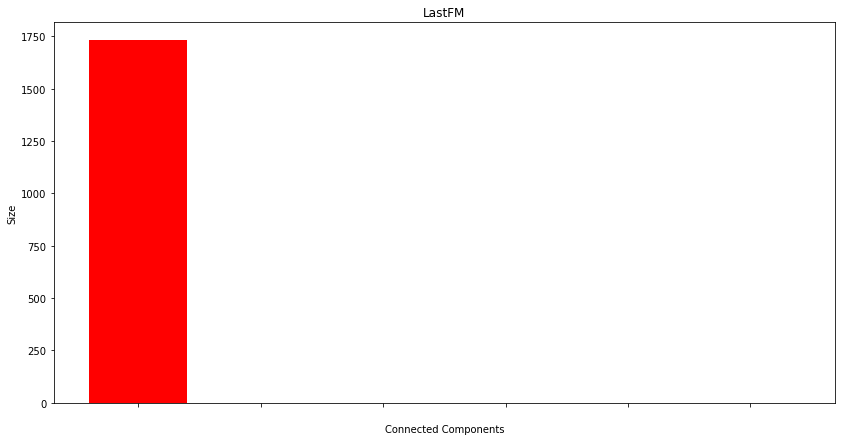

In [32]:
#bar plot of cc

cc = nx.weakly_connected_components(s)
data = [len(c) for c in sorted(cc, key=len, reverse=True)]

plt.figure(figsize=(14,7)) 
#plt.bar(list(range(len(data))), data, color = 'r', log=False)
plt.bar([1,2,3,4,5,6], [1730,0,0,0,0,0], color = 'r', log=False)
plt.title('LastFM') 
#plt.ylim(0,1050)
#plt.xlim(0,100)
plt.xlabel('Connected Components') 
plt.xticks(color='w')
plt.ylabel('Size') 
plt.show()

## Community Detection

In [ ]:
#summary
s = nx.from_numpy_matrix(np.matrix(S.A), create_using=nx.Graph)

In [ ]:
t0 = time.time()
community = greedy_modularity_communities(s, weight=None)
t1 = time.time()
print('Running time:', round(t1-t0,2)) 

In [ ]:
# Assing to each node the community of the supernode it belongs to

communityS = []
for idx in range(len(community)):
    comm_idx = []
    for el in community[idx]:
        for node in partition[el]:
            comm_idx.append(node)
    communityS.append(comm_idx)

In [ ]:
#modularity score
print(round(nx_comm.modularity(G, communityS),2))